In [ ]:
# Cell A: run this first (it will restart the Colab runtime)
# Reinstall compatible numpy + opencv and remove conflicting packages
!pip uninstall -y opencv-python opencv-python-headless numpy || true
!pip install --no-cache-dir --upgrade numpy==1.26.4
!pip install --no-cache-dir opencv-python-headless==4.7.0.72

# sanity: print versions then restart the runtime to ensure changes load
import sys, os, subprocess, json
print("Requested installs done. numpy version (post-install):")
import numpy as np
print(np.__version__)

# Force restart the Python runtime (this will kill the process; Colab will reconnect)
print("Restarting runtime to apply changes...")
os.kill(os.getpid(), 9)


Found existing installation: opencv-python-headless 4.7.0.72
Uninstalling opencv-python-headless-4.7.0.72:
  Successfully uninstalled opencv-python-headless-4.7.0.72
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 305.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 193.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.7.0.72 which is incompatible.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.7.0.72 which is incompatible.
^C


numpy: 1.26.4
cv2: 4.7.0
Downloaded image to: /content/results_project1/road_input.jpg


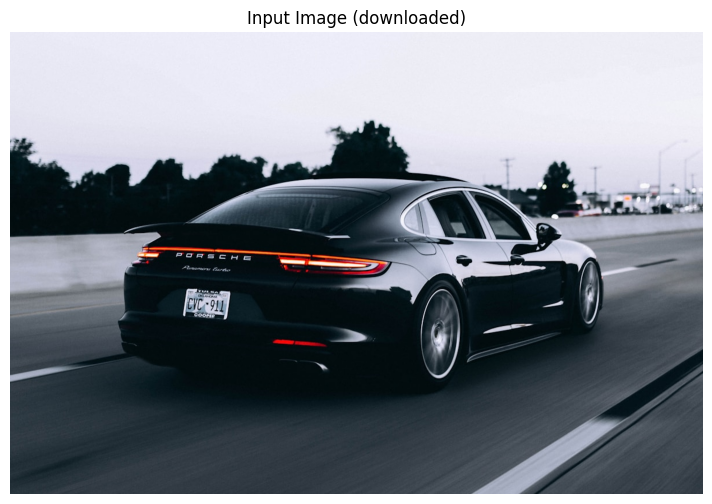

Saved outputs to /content/results_project1


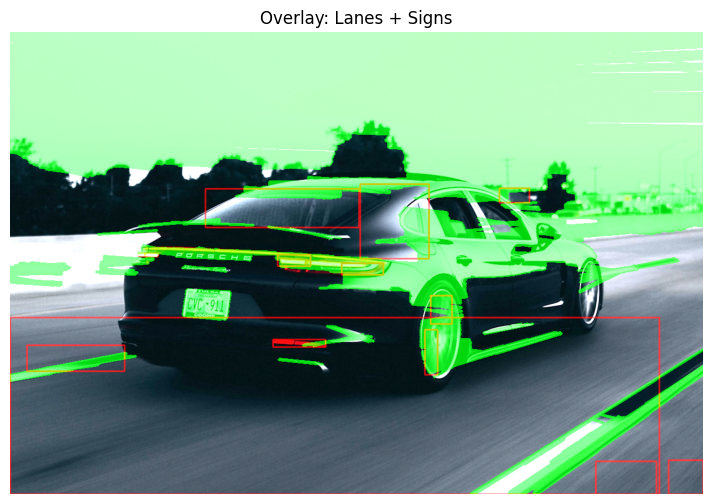

Done — if you want to download results, run the cell below to zip and download.


In [1]:
# Cell B: run after the runtime restarts
import sys, os, json
import cv2, numpy as np, matplotlib.pyplot as plt, requests
from pathlib import Path
from google.colab import files

print("numpy:", np.__version__)
print("cv2:", cv2.__version__)

RESULTS_DIR = '/content/results_project1'
os.makedirs(RESULTS_DIR, exist_ok=True)

def show_bgr(img_bgr, title=''):
    import matplotlib.pyplot as plt
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6)); plt.imshow(img_rgb); plt.title(title); plt.axis('off'); plt.show()

# Download a reliable road image (Unsplash) with UA header
url = "https://images.unsplash.com/photo-1503376780353-7e6692767b70?auto=format&w=1200"
headers = {'User-Agent': 'Mozilla/5.0'}
resp = requests.get(url, headers=headers, timeout=15)
resp.raise_for_status()
arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
if img is None:
    raise RuntimeError("Image decode failed. You can upload an image instead.")
in_path = os.path.join(RESULTS_DIR, 'road_input.jpg')
cv2.imwrite(in_path, img)
print("Downloaded image to:", in_path)
show_bgr(img, "Input Image (downloaded)")

# Simple lane detection pipeline (same as provided earlier)
def lane_mask_edges(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    lower_white, upper_white = np.array([0,0,200]), np.array([180,40,255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    lower_y, upper_y = np.array([15,80,120]), np.array([40,255,255])
    mask_yellow = cv2.inRange(hsv, lower_y, upper_y)
    mask = cv2.bitwise_or(mask_white, mask_yellow)
    edges = cv2.Canny(gray, 50, 150)
    combined = cv2.bitwise_or(mask, edges)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed

def hough_lane_overlay(img_bgr, edge_mask):
    lines = cv2.HoughLinesP(edge_mask, 1, np.pi/180, threshold=60, minLineLength=60, maxLineGap=25)
    overlay = img_bgr.copy()
    lines_list = []
    if lines is not None:
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(overlay, (x1,y1), (x2,y2), (0,255,0), 3)
            lines_list.append([int(x1),int(y1),int(x2),int(y2)])
    return overlay, lines_list

def detect_signs(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    r1 = cv2.inRange(hsv, (0,70,50), (10,255,255))
    r2 = cv2.inRange(hsv, (170,70,50), (180,255,255))
    red = cv2.bitwise_or(r1, r2)
    blue = cv2.inRange(hsv, (90,60,50), (140,255,255))
    combined = cv2.bitwise_or(red, blue)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    combined = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = img_bgr.copy()
    signs = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 250: continue
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay, (x,y), (x+w, y+h), (0,0,255), 2)
        signs.append({'bbox':[int(x),int(y),int(w),int(h)], 'area':int(area)})
    return overlay, signs

edges = lane_mask_edges(img)
overlay_lanes, lines = hough_lane_overlay(img, edges)
overlay_signs, signs = detect_signs(img)
final_overlay = cv2.addWeighted(overlay_lanes, 0.8, overlay_signs, 0.8, 0)

out_overlay = os.path.join(RESULTS_DIR, 'overlay_output.jpg')
out_mask = os.path.join(RESULTS_DIR, 'lane_mask.jpg')
cv2.imwrite(out_overlay, final_overlay)
cv2.imwrite(out_mask, edges)

summary = {
    "input": in_path,
    "overlay": out_overlay,
    "lane_mask": out_mask,
    "detected_lines": lines,
    "detected_signs": signs
}
with open(os.path.join(RESULTS_DIR, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("Saved outputs to", RESULTS_DIR)
show_bgr(final_overlay, "Overlay: Lanes + Signs")
print("Done — if you want to download results, run the cell below to zip and download.")

